In [73]:
import random 
import shutil
import os
from os import listdir as ls
from os.path import join, isdir, isfile
import matplotlib.pyplot as plt
import numpy as np



from torch.utils.data.sampler import SubsetRandomSampler

import re
import json 
import copy
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

import networkx as nx
import copy
import time
import importlib

import sys
sys.path.append('/home/mdso/lepetitp/ppc/WEBCAMS/src/raincell')

In [74]:
def moving_average(data, window_size):
    """
    Smooth a list of points using a moving average.

    Parameters:
    - data (list): The input list of points.
    - window_size (int): The size of the moving average window.

    Returns:    - smoothed_data (list): The smoothed list of points.
    """
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0.")

    half_window = window_size // 2
    smoothed_data = []

    for i in range(len(data)):
        start_index = max(0, i - half_window)
        end_index = min(len(data), i + half_window + 1)
        window_values = data[start_index:end_index]
        average = sum(window_values) / len(window_values)
        smoothed_data.append(average)

    return smoothed_data

# Example usage:
# data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# window_size = 3
# smoothed_data = moving_average(data, window_size)

# print("Original data:", data)
# print("Smoothed data:", smoothed_data)

In [75]:
dir_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240814"
print([cp  for cp in sorted(ls(dir_models)) if '_le' in cp])
# meilleure idée : 2 j + scheduler + weighting sqrt (non linear)

"""
names_checkpoint = ['20240506_exp0_UNet_causal_lr1step_size10000_gamma300_crop_size11520_le.checkpoint', 
                    '20240506_exp1_ss30_UNet_causal_lr3step_size30_gamma300_crop_size11520_le.checkpoint',
                    '20240506_exp2_1j_UNet_causal_lr1step_size10000_gamma300_crop_size5760_le.checkpoint', 
                    '20240506_exp3_weightinglinear_UNet_causal_lr1step_size10000_gamma300_crop_size11520_le.checkpoint']

#  scheduler : Dépend de ce qu'on veut. En "jamais vu" : mieux vaut 30 ep. sinon, mieux vaut 50 ep. Effet de le norm : indolore, de la daug naïve: dégrade
names_checkpoint = [
                    '20240506_exp1_ss30_UNet_causal_lr3step_size30_gamma300_crop_size11520_le.checkpoint',
                    '20240510_exp4_ss50_UNet_causal_lr3step_size50_gamma300_crop_size11520_le.checkpoint', 
                    '20240510_exp5_ss50_UNet_causal_lr3step_size50_gamma300_crop_size11520_le.checkpoint',
                    '20240510_exp6_ss50_UNet_causal_lr3step_size50_gamma300_crop_size11520_le.checkpoint',
                    '20240515_exp8_ss50_UNet_causal_lr1step_size50_gamma300_crop_size11520_le.checkpoint',
                   ]
# effet du padding sur la validation -> UNet causal 5mn (on s'est rendu compte du pb lié au maxpoooling), effet de la taille du réseau
# bizarre améliration en causal 5min : le modèle aurait-il appris le time step ?
names_checkpoint = [
                    '20240506_exp1_ss30_UNet_causal_lr3step_size30_gamma300_crop_size11520_le.checkpoint',
                    '20240518_exp11_size16_UNet_causal_lr1step_size30_gamma300_crop_size11520_le.checkpoint', 
                    '20240518_exp12_newvaltrim_UNet_causal_lr1step_size30_gamma300_crop_size11520_le.checkpoint',
                    '20240518_exp10_5mn_UNet_causal_5mn_lr1step_size30_gamma300_crop_size11520_le.checkpoint',
                    '20240518_exp14_UNet_causal_5mn_size128_UNet_causal_5mn_lr1step_size30_gamma300_crop_size11520_le.checkpoint'
]

# non causal : à quelle échelle ?
names_checkpoint = [
    '20240506_exp1_ss30_UNet_causal_lr3step_size30_gamma300_crop_size11520_le.checkpoint',
    '20240515_exp7_ss30_UNet_causal_lr1step_size30_gamma300_crop_size2880_le.checkpoint',
    '20240515_exp9_ss30_UNet_lr1step_size30_gamma300_crop_size11520_le.checkpoint',
    '20240518_exp13_UNet_lr1step_size30_gamma300_crop_size2880_le.checkpoint',
    '20240521_exp15_UNet_lr1step_size30_gamma300_crop_size576_le.checkpoint',
]
# causal 5 min (+atrous) : compa avec "causal" et à quelle échelle ?

names_checkpoint = [
'20240506_exp1_ss30_UNet_causal_lr3step_size30_gamma300_crop_size11520_le.checkpoint',
'20240518_exp10_5mn_UNet_causal_5mn_lr1step_size30_gamma300_crop_size11520_le.checkpoint', 
'20240518_exp13_first_atrous_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_le.checkpoint',
'20240521_exp16_UNet_1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size2880_le.checkpoint',
'20240521_exp18_atrous_long_receptive_field_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_le.checkpoint',
'20240521_exp19_1mn_atrous_long_receptive_field_UNet_1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size2880_le.checkpoint',
'20240521_exp20_atrous_long_receptive_field_50_sm128_UNet_causal_5mn_atrous_lr1step_size50_gamma300_crop_size11520_le.checkpoint',
    '20240521_exp15_UNet_lr1step_size30_gamma300_crop_size576_le.checkpoint',
]


# focus pb échelle

names_checkpoint = [
'20240521_exp18_atrous_long_receptive_field_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_le.checkpoint',
'20240521_exp19_1mn_atrous_long_receptive_field_UNet_1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size2880_bm.checkpoint',
'20240521_exp20_atrous_long_receptive_field_50_sm128_UNet_causal_5mn_atrous_lr1step_size50_gamma300_crop_size11520_le.checkpoint',
# '20240521_exp21_pseudo1mn_atrous_long_receptive_field_UNet_pseudo1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_crop_step4_le.checkpoint',
]


names_checkpoint = [
    '20240521_corrtransf_exp22_pseudo1mn_atrous_long_receptive_field_UNet_pseudo1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_crop_step4_le.checkpoint',
    '20240521_exp23_corrtransf_atrous_long_receptive_field_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_crop_step1_le.checkpoint',
    '20240521_corrtransf_exp24_1mn_atrous_long_receptive_field_UNet_1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size2880_crop_step1_le.checkpoint',
     '20240521_corrtransf_exp25_atrous_long_receptive_field_nocomp_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_crop_step1_le.checkpoint',                   
]

names_checkpoint+= [
    '20240524_corrtransf_exp25_pseudo1mn_atrous2_UNet_pseudo1mn_causal_5mn_atrous2_lr1step_size30_gamma300_crop_size12720_crop_step4_le.checkpoint',
'20240524_corrtransf_exp26_pseudo1mn_atrous_UNet_pseudo1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_crop_step4_le.checkpoint',
    '20240524_corrtransf_exp27_1mn_atrous_UNet_1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size3180_crop_step1_le.checkpoint',
    '20240524_corrtransf_exp28_1mn_atrous_modeinverse_UNet_1mn_causal_5mn_atrous_lr1step_size30_gamma300_crop_size3180_crop_step1_le.checkpoint'
    
]
"""




names_checkpoint = [
    '20240506_exp0_UNet_causal_lr1step_size10000_gamma300_crop_size11520_le.checkpoint', 
    '20240526_exp29_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240526_exp30_atrous_long_receptive_field_longepoch_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240526_exp31_atrous_long_receptive_field_longerpoch_sm128_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
  #  '20240526_exp32_short_DeepLab_DeepLab_causal_5mn_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint',
    # '20240526_exp32_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240601_exp33_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240531_exp34_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240613_exp36_rmse_mae_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240613_exp37_rmse_mae_quartiles_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240531_exp38_dbs_dbci_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240531_exp39_dbs_dbci_atrous_quartiles_rmse_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240601_exp35_linear_balanced_loss_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint'
                    ]


names_checkpoint = [
        '20240526_exp29_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240526_exp31_atrous_long_receptive_field_longerpoch_sm128_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240601_exp33_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240531_exp34_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240617_exp40_CE_MSE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240617_exp41_CE_MSE_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240617_exp42_CE_MSE_MAE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240617_exp43_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240531_exp38_dbs_dbci_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
  '20240613_exp36_rmse_mae_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240622_exp44_target_cumsum_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_bm.checkpoint',    
]

#MSE
# Voir l'effet de l'accès à l'ID sur des UNet non causaux (pas exploitable malheureusement)
# names_checkpoint = [
#     '20240601_exp33_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240613_exp36_rmse_mae_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240617_exp42_CE_MSE_MAE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240617_exp43_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240712_exp46_UNet_CE_MSE_tcs_UNet_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240712_exp47_UNet_CE_MSE_tcs_UNet_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240712_exp45_UNet_learned_outputs_rescaling_CE_MSE_tcs_UNet_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
#     '20240715_exp48_UNet_learned_outputs_rescaling_CE_MSE_no_tcs_UNet_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint'
# ]

# 




# pour voir l'effet de l'accès à l'id sur des UNet - atrous causaux et l'effet de viser une MSE 1h
"""
names_checkpoint = [
    '20240601_exp33_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240613_exp36_rmse_mae_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240805_exp50_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240805_exp51_UNet_causal_5mn_atrous_learned_outputs_complexe_rescaling_CE_MSE_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240805_exp52_UNet_causal_5mn_atrous_learned_outputs_complexe_rescaling_CE_MSE_fixed_cumul_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240508_exp53_CE_MSE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240508_exp54_CE_MSE_MSE1h_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240508_exp55_CE_MSE_MSEsum5min_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    '20240807_exp56_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint'
]
"""    

# MAE et fixed cumul pas compatible avec MAE:
# names_checkpoint = [
#    '20240613_exp36_rmse_mae_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
#    '20240613_exp37_rmse_mae_quartiles_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
#    '20240531_exp39_dbs_dbci_atrous_quartiles_rmse_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',

# ]

#Evolution du CSI, etc

# names_checkpoint = [
#     '20240526_exp29_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint',
#     '20240526_exp30_atrous_long_receptive_field_longepoch_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint',
#     '20240526_exp31_atrous_long_receptive_field_longerpoch_sm128_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_bm.checkpoint',
#     '20240526_exp32_short_DeepLab_DeepLab_causal_5mn_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint'
#                     ]


['20240616_exp70_CE_MSE_MAE_fc_UNet_causal_5mn_atrous_lr0step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint', '20240616_exp70_CE_weightedmaskedMSE_fc_UNet_causal_5mn_atrous_rescale_lr0step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint', '20240617_exp61_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size20_gamma300_crop_size12720_crop_step1_le.checkpoint', '20240617_exp61_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint', '20240814_exp57_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_bm.checkpoint', '20240814_exp57_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_bmi.checkpoint', '20240814_exp57_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint'

"\nnames_checkpoint = [\n    '20240601_exp33_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',\n    '20240613_exp36_rmse_mae_fixed_cumul_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',\n    '20240805_exp50_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',\n    '20240805_exp51_UNet_causal_5mn_atrous_learned_outputs_complexe_rescaling_CE_MSE_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',\n    '20240805_exp52_UNet_causal_5mn_atrous_learned_outputs_complexe_rescaling_CE_MSE_fixed_cumul_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',\n    '20240508_exp53_CE_MSE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',\n    '202

In [76]:
dir_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240814"
print([cp  for cp in sorted(ls(dir_models)) if  ('exp89' in cp) and ('_le.' in cp) ])

[]


In [77]:

names_checkpoint = [
    # '20240601_exp33_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
    # '20240617_exp43_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
     ('20240807_exp56_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
      'jeu 04/30; CE MSE, lor, dbci + dbs + fc, ss 90'),
    ('20240617_exp61_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE Q4, rr + dbci + dbs, ss 45'),
                    # ('20240814_exp57_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
                    #   'fc bad'),                    
                    ('20240814_exp58_CE_MSE_MAE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
                     'CE MSE MAE, rr + dbci + dbs, ss 90'),
                    # '20240814_exp60_CE_MSE_fc_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                    ('20240814_exp60_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                     'CE MAE, ss 45'),
                    ('20240814_exp62_Unet_UNet_causal_5mn_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                     'UNet causal 5mn, ss 45'),
                     ('20240814_exp63_CE_MSE_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                     'CE MSE,  nolrc, rr, ss 90'),
]

names_checkpoint = [
('20240815_exp64_CE_MSE_MAE_fc_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint', 
 'CE MSE MAE, rr + dbci + dbs, ss 45 = exp58'),
# ('20240815_exp64_CE_MSE_fc_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
('20240815_exp65_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_rescale_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint', 
 'CE MSE, lor, ss 45'),
('20240815_exp66_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_rescale_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE MSE MAE, lor, dbci + dbs, ss 45'),
    ('20240815_exp67_UNet_causal_5mn_atrous_learned_maskedMSE_CE_maskedMSE_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE maskedMSE, dbci + dbs, ss 40'),
     # ('20240815_exp68_UNet_causal_5mn_atrous_learned_maskedMSE_fc_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint', 'echec')
('20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE MSE MAE, rr + dbci + dbs, ss 15'),
    ('20240616_exp70_CE_weightedmaskedMSE_fc_UNet_causal_5mn_atrous_rescale_lr0step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE weighted (strong in first steps) maskedMSE, lor, rr + dbci + fc, lr 0.0005, ss 15'),
    ('20240816_exp71_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, lor, dbci,  ss 15'),
    # ('20240816_exp72_CE_MSE_20_dbs_fc_lor_bs64_UNet_causal_5mn_atrous_rescale_lr0step_size20_gamma300_crop_size12720_crop_step1_le.checkpoint','echec'),
    ('20240816_exp72_CE_weightedmaskedMSE_20_dbs_fc_UNet_causal_5mn_atrous_lr1step_size20_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE weightedmaskedMSE, rr + dbci + dbs + fc, ss 20'),
    ('20240816_exp73_CE_MSE_1min_dbs_UNet_1mn_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE, res 1 min, rr + dbci + dbs, ss 90, ste/5'),
    ('20240815_exp74_UNet_causal_5mn_atrous_learned_CE_maskedMSE_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, dbci + dbs, ss 30, ste /3, (=exp67)'),
    ('20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, lor, dbci, ss 30, ste/3 (=exp71)'),
    ('20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE maskedMAE, lor, dbci + dbs, ss 30, ste/3'),
    ('20240817_exp77_UNet_causal_5mn_atrous_learned_CE_maskedMSE_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE weightedmaskedMSE, dbci + dbs + fc, ss 30, ste/3'),
    ('20240817_exp78_CE_maskedMSE_maskedQ_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE maskedQ4, rr + dbci + dbs, ss 30, ste/3'),

]


# effet rr: pas négatif (on aurait dû l'utiliser tout le temps ! eg exp 76)
names_checkpoint2 = [
('20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE MSE MAE, rr + dbci + dbs, ss 15'),
('20240814_exp58_CE_MSE_MAE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE MSE MAE, rr + dbci + dbs, ss 90'),
    ('20240815_exp64_CE_MSE_MAE_fc_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint', 
 'CE MSE MAE, rr + dbci + dbs, ss 45 = exp58'),
    ('20240815_exp66_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_rescale_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE MSE MAE, lor, dbci + dbs, ss 45'),
]

# meilleur convergence en masked loss. 
# - weighted masked partent en cacahuète. Peut-être mieux en rr et masquage  -> dernier essai.
names_checkpoint = [
    ('20240815_exp67_UNet_causal_5mn_atrous_learned_maskedMSE_CE_maskedMSE_UNet_causal_5mn_atrous_lr1step_size40_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE maskedMSE, dbci + dbs, ss 40'),
    # ('20240616_exp70_CE_weightedmaskedMSE_fc_UNet_causal_5mn_atrous_rescale_lr0step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
    #  'CE weighted (strong in first steps) maskedMSE, lor, rr + dbci + fc, lr 0.0005, ss 15'),
    ('20240816_exp71_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, lor, dbci,  ss 15'),
    # ('20240816_exp72_CE_MSE_20_dbs_fc_lor_bs64_UNet_causal_5mn_atrous_rescale_lr0step_size20_gamma300_crop_size12720_crop_step1_le.checkpoint','echec'),
    # ('20240816_exp72_CE_weightedmaskedMSE_20_dbs_fc_UNet_causal_5mn_atrous_lr1step_size20_gamma300_crop_size12720_crop_step1_le.checkpoint',
    #  'CE weightedmaskedMSE, rr + dbci + dbs + fc, ss 20'),
    ('20240815_exp74_UNet_causal_5mn_atrous_learned_CE_maskedMSE_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, dbci + dbs, ss 30, ste /3, (=exp67)'),
    ('20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, lor, dbci, ss 30, ste/3 (=exp71)'),
    ('20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE maskedMAE, lor, dbci + dbs, ss 30, ste/3'),
    # ('20240817_exp77_UNet_causal_5mn_atrous_learned_CE_maskedMSE_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
    #  'CE weightedmaskedMSE, dbci + dbs + fc, ss 30, ste/3'),
    ('20240817_exp78_CE_maskedMSE_maskedQ_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE maskedQ4, rr + dbci + dbs, ss 30, ste/3'),
    ( '20240818_exp79_maskedMSE_maskedMAE_2_UNet_causal_5mn_atrous_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
    'CE maskedMSE maskedMAE, lor, rr + dbci + dbs, ss 15, ste/2'),
    ( '20240818_exp80_maskedMSE_maskedMAE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
    'CE maskedMSE maskedMAE, lor + fc, rr + dbci + dbs, ss 15, ste/2'),
        ('20240816_exp81_CE_maskedMSE_lorc_rr_dbci_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE, rr + dbci + locr, ss 15, ste x2/3'),     
]

#En non masked loss:
names_checkpoint += [
     ('20240807_exp56_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
      'jeu 04/30; CE MSE, lor, dbci + dbs + fc, ss 90'),
    ('20240617_exp61_CE_MSE_Q_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE Q4, rr + dbci + dbs, ss 45'),
    ('20240814_exp58_CE_MSE_MAE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE MAE, rr + dbci + dbs, ss 90'),
    ('20240815_exp66_atrous_long_receptive_field_longerpoch_UNet_causal_5mn_atrous_rescale_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE MAE, lor, dbci + dbs, ss 45'),
     ('20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'CE MSE MAE, rr + dbci + dbs, ss 15'),
    ('20240816_exp73_CE_MSE_1min_dbs_UNet_1mn_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE, res 1 min, rr + dbci + dbs, ss 90, ste/5'),
    ('20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE maskedMAE, lor, dbci + dbs, ss 30, ste/3'),
    ('20240816_exp73_CE_MSE_1min_dbs_UNet_1mn_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE, res 1 min, rr + dbci + dbs, ss 90, ste/5'),
]
#Après le premier test:
# effet positif net du rr(exp79  vs exp 76, mais différents ss!!) et du travail à fine échelle en matière de segmentation.
names_checkpoint = [
    ('20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'exp75 CE maskedMSE, lor, dbci, ss 30, ste/3 (=exp71)'),
    ('20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'exp76 CE maskedMSE maskedMAE, lor, dbci + dbs, ss 30, ste/3'),
    ('20240817_exp78_CE_maskedMSE_maskedQ_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'exp78 CE maskedMSE maskedQ4, rr + dbci + dbs, ss 30, ste/3'),
    ( '20240818_exp79_maskedMSE_maskedMAE_2_UNet_causal_5mn_atrous_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
    'exp79 CE maskedMSE maskedMAE, lor, rr + dbci + dbs, ss 15, ste/2'),
        ('20240816_exp81_CE_maskedMSE_lorc_rr_dbci_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'exp81 CE maskedMSE, rr + dbci + locr, ss 15, ste x2/3'),     
     ('20240807_exp56_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
      'exp56 jeu 04/30; CE MSE, lor, dbci + dbs + fc, ss 90'),
     ('20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
 'exp69 CE MSE MAE, rr + dbci + dbs, ss 15'),
    ('20240816_exp73_CE_MSE_1min_dbs_UNet_1mn_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'exp73 CE MSE, res 1 min, rr + dbci + dbs, ss 90, ste/5'),

('20240822_exp82_fc_lor_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
'exp82 CE maskedMSE, fc, lor + dbci, ss 30, ste/3'),
('20240822_exp83_CE_maskedMSE_locr2_dbci_UNet_causal_5mn_atrous_complexe_rescale2_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
'exp83 CE maskedMSE, locr2, dbci, ss 30, ste/3'),
('20240822_exp83_CE_maskedMSE_locr2_dbci_dbs_rrg_gci_UNet_causal_5mn_atrous_complexe_rescale2_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
    'exp84 CE maskedMSE, locr2, dbci, rrg, gci, dbs, ss 30, ste/3'),
('20240822_exp83_CE_maskedMSE_lor_dbci_dbs_rrg_gci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
    'exp85 CE maskedMSE, lor, dbci, rrg, gci, dbs, ss 30, ste/3'),
('20240823_exp86_CE_maskedMSE_lor_dbci_dbs_rrg_gci_fc_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
'exp86 CE MaskedMSE lor dbci dbs rrg gci fc'),
('20240823_exp87_CE_maskedMSE_locr_dbci_dbs_rrg_gci_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
'exp87 CE MAskedMSE, locr, dbci dbs rrg gci'),
('20240823_exp88_CE_maskedMSE_locr_dbci_dbs_rrg_gci_UNet_causal_5mn_atrous_complexe_rescale2_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
'exp88 train GPU CE MAskedMSE, locr2, dbci dbs rrg gci fc'),
]
    

In [28]:
# Figure 1 : Effet de lrc, 1 min
names_checkpoint = [
# '20240815_exp64_CE_MSE_MAE_fc_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                    ('20240814_exp62_Unet_UNet_causal_5mn_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                     'UNet causal 5mn, ss 45'),
                     ('20240814_exp63_CE_MSE_UNet_causal_5mn_atrous_lr1step_size45_gamma300_crop_size12720_crop_step1_le.checkpoint',
                     'CE MSE, nolrc, rr, ss 90'),
    ('20240814_exp58_CE_MSE_MAE_UNet_causal_5mn_atrous_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE MAE, rr + dbci + dbs, ss 90'),
    ('20240816_exp73_CE_MSE_1min_dbs_UNet_1mn_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE MSE, res 1 min, rr + dbci + dbs, ss 90, ste/5'),
    ('20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint',
     'CE maskedMSE maskedMAE, lor, dbci + dbs, ss 30, ste/3'),
]
# window : 4, nb epochs : 24

20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint
20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint
20240817_exp78_CE_maskedMSE_maskedQ_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_le.checkpoint
20240818_exp79_maskedMSE_maskedMAE_2_UNet_causal_5mn_atrous_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint
20240816_exp81_CE_maskedMSE_lorc_rr_dbci_UNet_causal_5mn_atrous_complexe_rescale_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint
20240807_exp56_UNet_causal_5mn_atrous_learned_outputs_rescaling_CE_MSE_fc_UNet_causal_5mn_atrous_rescale_lr1step_size90_gamma300_crop_size12720_crop_step1_le.checkpoint
20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_le.checkpoint
20240816_exp73_CE_MSE_1min_dbs_UNet_1mn_causal_5mn_at

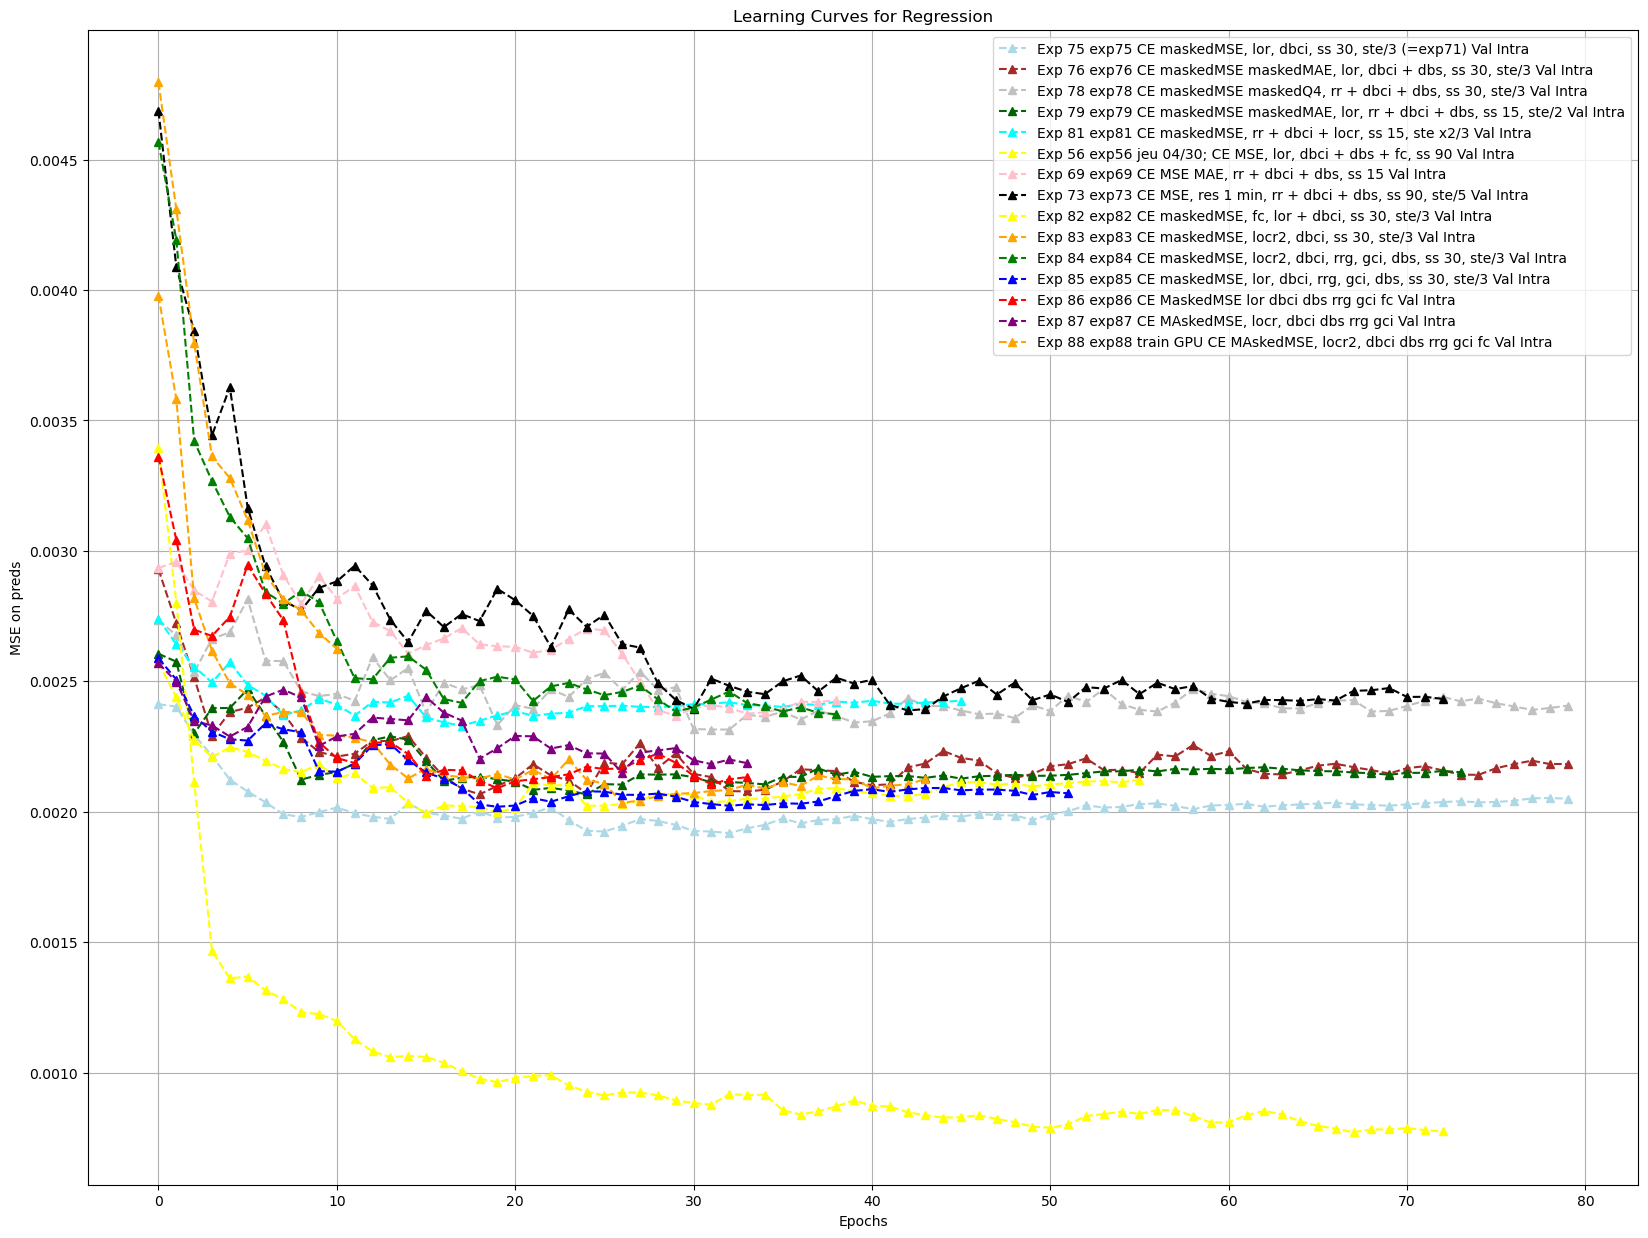

In [84]:
import matplotlib.pyplot as plt
import torch
from os.path import join
def compute_metrics(confusion_matrix):
    tp = confusion_matrix[1, 1]
    tn = confusion_matrix[0, 0]
    fp = confusion_matrix[0, 1]
    fn = confusion_matrix[1, 0]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    csi = tp / (tp + fn + fp) if (tp + fn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    false_alarm_ratio = fp / (tp + fp) if (tp + fp) > 0 else 0

    return accuracy, csi, sensitivity, specificity, false_alarm_ratio
    
k = 0
l = 80 #None
window_size = 2
device = torch.device('cpu')
# Define a variable to choose the plot type
plot_type = 'regression'  
mode = 'MAE'
mode = 'MSE on preds'
# mode = 'MSE on gt'
# plot_type = 'segmentation'  
# mode = 'losses'
# mode = 'csi'
# mode = 'far'
# mode = 'pod'
# Define colors for up to 10 experiments for visual diversity
experiment_colors = ['green', 'blue', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'gold', 'black', 'lightgreen', 'lightblue', 'brown',
                    'yellow', 'silver', 'darkgreen', 'palegreen', 'cyan', 'yellow', 'orange']

plt.figure(figsize=(20, 15))

# Iterate over each checkpoint
for i, checkpoint in enumerate(names_checkpoint):
    name_checkpoint = checkpoint[0]
    description = checkpoint[1]
    # Extracting the experiment number using string splitting
    # for j, n in enumerate(description.split(' ')):
    #     if 'exp' in n:
    #         break
    n = description.split(' ')[0]
    experiment_number = n.replace('exp', '') 
    
    experiment_index = int(experiment_number)  # Convert to integer to use as an index for colors
    experiment_desc = description #' '.join(name_checkpoint.split('_')[(j+1):])
    description = description[6:]
    # if name_checkpoint == '20240518_exp13_first_atrous_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size11520_le.checkpoint':
    #     experiment_index=17
    #     experiment_desc='first atrous' 
    

    print(name_checkpoint)
    if experiment_index <= 56:
        dir_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240430"
    else:
        dir_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240814"
        
    path_checkpoint = join(dir_models, name_checkpoint)
    checkpoint = torch.load(path_checkpoint, map_location=device)

    train_losses = checkpoint['train_losses'][k:l]
    val_intra_losses = checkpoint['val_intra_losses'][k:l]
    val_inter_losses = checkpoint['val_inter_losses'][k:l]
    epochs = [x[0] for x in train_losses]

    if plot_type == 'regression' and mode == 'MAE':
        # Fetch regression losses
        train_losses = [x[1] for x in train_losses]
        val_intra_losses = [x[1] for x in val_intra_losses]
        val_inter_losses = [x[1] for x in val_inter_losses]

    elif plot_type == 'regression' and mode == 'MSE on preds':
        # Fetch regression losses
        try :
            train_losses = [x[4] for x in train_losses]
            val_intra_losses = [x[4] for x in val_intra_losses]
            val_inter_losses = [x[4] for x in val_inter_losses]
        except:
            train_losses = [0*x[0] for x in train_losses]
            val_intra_losses = [0*x[0] for x in val_intra_losses]
            val_inter_losses = [0*x[0] for x in val_inter_losses]            

    elif plot_type == 'regression' and mode == 'MSE on gt':
        # Fetch regression losses
        train_losses = []
        val_intra_losses_ = []
        val_inter_losses_ = []
        
        for x in val_intra_losses:           
            try :
                val_intra_losses_.append(x[5])
            except:
                val_intra_losses_.append(0.)
                
        for x in val_inter_losses:           
            try :
                val_inter_losses_.append(x[5])
            except:
                val_inter_losses_.append(0.)
        
        val_intra_losses = val_intra_losses_
        val_inter_losses = val_inter_losses_
    
    elif plot_type == 'regression' and mode == 'MSE':
        # Fetch regression losses
        train_losses = []
        val_intra_losses_ = []
        val_inter_losses_ = []
        
        for x in val_intra_losses:           
            try :
                val_intra_losses_.append(x[6])
            except:
                val_intra_losses_.append(x[4])
                
        for x in val_inter_losses:           
            try :
                val_inter_losses_.append(x[6])
            except:
                val_inter_losses_.append(x[4])
                
        val_intra_losses = val_intra_losses_
        val_inter_losses = val_inter_losses_

    elif plot_type == 'segmentation':
        # Fetch segmentation losses
        if mode == 'losses':
            train_losses = [x[2] for x in train_losses]
            val_intra_losses = [x[2] for x in val_intra_losses]
            val_inter_losses = [x[2] for x in val_inter_losses]
        if mode == 'csi':
            # outptus : accuracy, csi, sensitivity, specificity, false_alarm_ratio
            kr = 1
            # train_losses = [compute_metrics(x[3])[k] for x in train_losses]
            val_intra_losses = [compute_metrics(x[3])[kr] for x in val_intra_losses]
            val_inter_losses = [compute_metrics(x[3])[kr] for x in val_inter_losses]
        if mode == 'far':
            # outptus : accuracy, csi, sensitivity, specificity, false_alarm_ratio
            kr = 4
            # train_losses = [compute_metrics(x[3])[k] for x in train_losses]
            val_intra_losses = [compute_metrics(x[3])[kr] for x in val_intra_losses]
            val_inter_losses = [compute_metrics(x[3])[kr] for x in val_inter_losses]
        if mode == 'pod':
            # outptus : accuracy, csi, sensitivity, specificity, false_alarm_ratio
            kr = 2
            # train_losses = [compute_metrics(x[3])[k] for x in train_losses]
            val_intra_losses = [compute_metrics(x[3])[kr] for x in val_intra_losses]
            val_inter_losses = [compute_metrics(x[3])[kr] for x in val_inter_losses]        
    
    val_intra_losses = moving_average(val_intra_losses, window_size)
    val_inter_losses = moving_average(val_inter_losses, window_size)
    if experiment_index == 67:
        val_intra_losses = 10 * [0] +  val_intra_losses[10:]
        val_inter_losses = 10 * [0] +  val_inter_losses[10:]
        
    # Use the color index corresponding to the experiment number
    color = experiment_colors[experiment_index % len(experiment_colors)]  # Cycle through colors if >10 experiments

    # Plotting
    # plt.plot(epochs, train_losses, marker='o', color=color, label=f"Exp {experiment_number} {experiment_desc} Train")
    plt.plot(epochs, val_intra_losses, marker='^', color=color, linestyle='dashed', label=f"Exp {experiment_number} {experiment_desc} Val Intra")
    # plt.plot(epochs, val_inter_losses, marker='x', color=color, linestyle='dotted', label=f"Exp {experiment_number} {experiment_desc} Val Inter")

    
plt.title(f"Learning Curves for {plot_type.title()}")
plt.xlabel("Epochs")
plt.ylabel(mode)
# plt.ylim([0.0018,0.003])
plt.legend()
plt.grid(True)
plt.show()

In [399]:
len(epochs)

63

In [157]:
128*588

75264

['ilink', 'timestamp', 'attenuation_ab', 'attenuation_ba', 'pnp', 'precip_mm_h', 'pnpradtot', 'pnprada', 'pnpradb']
